<a href="https://colab.research.google.com/github/vanhry/House-Price-Predicting/blob/master/HousePricePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [0]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [1]:
def load_data(path):
    data = pd.read_csv(path)
    NA = data.isnull().sum()/data.shape[0]*100
    #print(data.shape[0])
    #print(NA[NA>50])
    dic = {False: 1, True: 0}
    data['HaveGarage'] = pd.isna(data['GarageCond']).map(dic)
    data['HaveFireplace'] = pd.isna(data['FireplaceQu']).map(dic)
    data['HaveBsmt'] = pd.isna(data['BsmtCond']).map(dic)
    data['HaveAlleyAccess'] = pd.isna(data['Alley']).map(dic)
    data['TotBathrooms'] = data['FullBath'] + data['HalfBath']*0.5 + data['BsmtFullBath'] + data['BsmtHalfBath']*0.5
    data['Remod'] = np.where(data['YearBuilt']==data['YearRemodAdd'], 0, 1)
    data['BsmtLotArea'] = data['LotArea']+data['TotalBsmtSF']
    data['Age'] = data['YrSold']-data['YearRemodAdd']
    data.drop(labels=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'],inplace=True,axis=1)
    return data
  
test = load_data('test.csv')
train = load_data('train.csv')

test_id = test.Id
train_id = train.Id

NameError: ignored

In [0]:
def split_datatypes(data):
    data = data.drop(labels=['HaveGarage','HaveBsmt','HaveFireplace',
                                      'HaveAlleyAccess'],axis=1)
    categorical = list(data.select_dtypes(include=['object']).columns.values)
    nominal = list(data.select_dtypes(include=['float64','int64']).columns.values)
    nominal.remove('Id')
    nominal.remove('SalePrice')
    return categorical, nominal
  
categorical, nominal = split_datatypes(train)

def split_X_y(data, train=True):
    global nominal
    data.drop(labels=['Id'],inplace=True,axis=1)
    if train:
        y = data.SalePrice
        data.drop(labels=['SalePrice'],inplace=True,axis=1)
        y = y.fillna(np.mean(y))
    else:
        y = None
    for column in data:
        if column in nominal:
            data[column] = data[column].fillna(data[column].mean())
        else:
            data[column] = data[column].fillna(data[column].mode())
    X = data
    return X,y


test_X, test_y = split_X_y(test,train=False)
train_X, train_y = split_X_y(train)

train_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,HaveGarage,HaveFireplace,HaveBsmt,HaveAlleyAccess,TotBathrooms,Remod,BsmtLotArea,Age
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,1,0,1,0,3.5,0,9306,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,1,1,1,0,2.5,0,10862,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,1,1,1,0,3.5,1,12170,6
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,1,1,1,0,2.0,1,10306,36
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,1,1,1,0,3.5,0,15405,8


In [0]:
train_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MoSold,YrSold,SaleType,SaleCondition,HaveGarage,HaveFireplace,HaveBsmt,HaveAlleyAccess,LastSold,BsmtLotArea
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,2,2008,WD,Normal,1,0,1,0,2,9306
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,5,2007,WD,Normal,1,1,1,0,3,10862
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,9,2008,WD,Normal,1,1,1,0,2,12170
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,2,2006,WD,Abnorml,1,1,1,0,4,10306
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,12,2008,WD,Normal,1,1,1,0,2,15405


In [0]:
#df = pd.DataFrame(np.random.randn(14,5), columns=list("ABCDE"))


#g = sns.FacetGrid(df.melt(), col="variable")
#g.map(sns.distplot, "value")



## **Standatizing data**

In [0]:
def normalize(X):
    numeric_features = X.drop(labels=['HaveGarage','HaveBsmt','HaveFireplace',
                                      'HaveAlleyAccess'],axis=1)
    numeric_features = X.loc[:,X.select_dtypes(include=['float64','int64']).columns]
    
    numeric_features_std = (numeric_features - numeric_features.mean())/numeric_features.std()
    data_standart = X.copy()
### Replacing numeric features by standardized values
    data_standart.update(numeric_features_std)
    return data_standart
  
test_X = normalize(test_X)
train_X = normalize(train_X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f156988dcc0>,
      dtype=object)

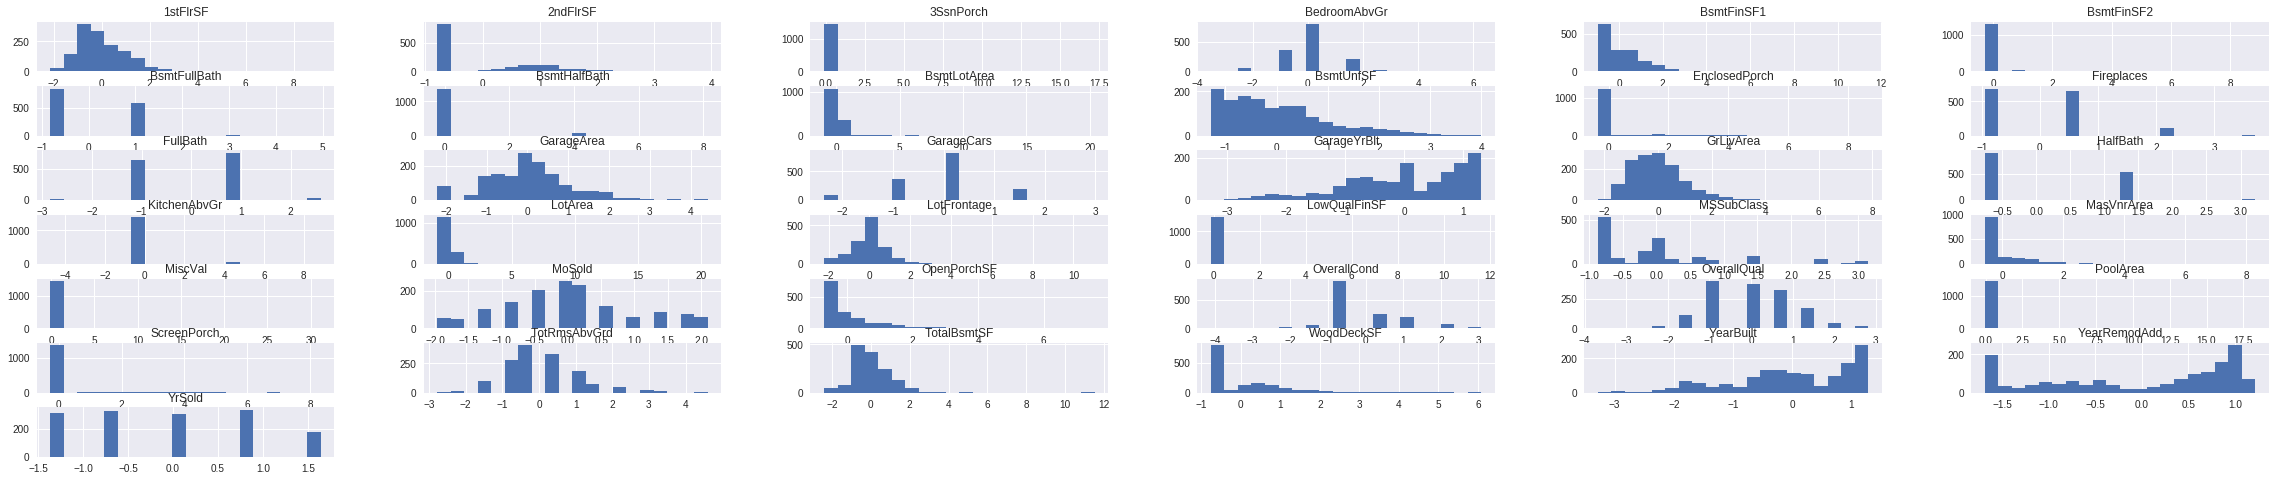

In [0]:
#train_X[nominal].boxplot(figsize=(40,8))
train_X[nominal].hist(figsize=(40,8),bins=20)

**DATA PREPROCESING**

In [0]:


def label_encoder(X):
    global categorical
    le = preprocessing.LabelEncoder()
    for cat in categorical:
        X[cat].fillna('UNK')
        X[cat] = le.fit_transform(X[cat].astype(str))
    return X

test_X = label_encoder(test_X)
train_X = label_encoder(train_X)
#test_X = pd.get_dummies(test_X, prefix=categorical)
#train_X  = pd.get_dummies(train_X, prefix=categorical)
#train_X.head()
#print(list(set(list(train_X.columns))-set(list(test_X.columns))))
#train_X.drop(labels=list(set(list(train_X.columns))-set(list(test_X.columns))), inplace=True,axis=1)

In [0]:
list(set(list(train_X.columns))-set(list(test_X.columns)))

[]

In [0]:
train_y = np.log(train_y)
#x_train , x_test , y_train , y_test = train_test_split(train_X,train_y, 
#                                                   test_size=0.1, random_state=5)
test_id.shape

(1459,)

In [0]:
#gbm = xgb.XGBRegressor(n_estimators=3000, learning_rate=0.1, max_depth=3, max_features='sqrt',
#                                               min_samples_leaf=15, min_samples_split=10, loss='huber')
gbm = xgb.XGBRegressor(
                learning_rate =0.01,
                n_estimators = 4000,
                max_depth=3,
                min_child_weight=1.1,
                gamma=0.01,
                subsample=0.72,
                colsample_bytree=0.89,
                reg_lambda = 0.61,
                reg_alpha = 0.53,
    
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

gbm.fit(train_X,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.89, gamma=0.01, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1.1, missing=None,
       n_estimators=4000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.53, reg_lambda=0.61, scale_pos_weight=1,
       seed=10, silent=True, subsample=0.72)

{'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_Mix',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'GarageQual_Ex',
 'Heating_Floor',
 'Heating_OthW',
 'HouseStyle_2.5Fin',
 'RoofMatl_ClyTile',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Utilities_NoSeWa'}

In [0]:
predictions = gbm.predict(test_X)

#print((mean_squared_error(predictions,y_test)**0.5))
#print(gbm.score(x_test,y_test))

#feature_importances = pd.Series(gbm.feature_importances_, train_X.columns.values)
#feature_importances = feature_importances.sort_values(ascending=False)
# feature_importance}s= feature_importances.head(40)
#feature_importances.plot(kind='bar', title='Feature Importances',figsize=(100,10))
#plt.ylabel('Feature Importance Score')

In [0]:
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, False)
scores = np.sqrt(-cross_val_score(gbm, train_X, train_y, cv=5, scoring=scorer))
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.1212 (+/- 0.0209)


In [0]:
pd.DataFrame({'Id':test_id,'SalePrice': np.exp(predictions)}).to_csv('2018-12-10.csv',index=False)

In [0]:
from google.colab import files


files.download('2018-12-10.csv')